In [ ]:
#import
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
import numpy.typing as npt
import os
import matplotlib.pyplot as plt





In [ ]:

class rlmc_env:
    """
    molecular dynamics environment for rienforcement learning
    "5N-spring2D" -- Simulation of 5 atoms connected with Hooks Law with random staring locations and zero velocity
    """

    def __init__(self, name: str, n: int, dt: float, reward_flag:str = "no energy") -> None:
        self.max_int = 65535
        self.seed = np.random.randint(self.max_int)
        np.random.seed(self.seed)
        self.simulation = name

        match self.simulation:
            case "N-spring2D":
                self.N = n
                self.D = 2
                self.m = 1
                self.reward_flag = reward_flag

                self.dt = dt  # time step

                # Simulation Constants
                self.ks = 1  # Spring Constant
                self.radius = 0.1  # Molecule Radius

                self.ts = 0  # current time step
                self.SoB = 5  # size of box

                self.r_init = np.zeros((self.N, self.D))
                self.v_init = np.zeros((self.N, self.D))
                self.v = self.v_init
                self.r = self.r_init
                self.terminate = False

                self.U_init = 0
                self.K_init = 0

            case "5N-lj2D":
                raise NotImplementedError("next implementation")
            case _:
                raise NotImplementedError("environment currently not implemented")

    def NNdims(self):
        """
        Return the input and output dimensions of the simulation.
        Use for defining NN input and output sizes
        """
        in_dim = 2 * self.N * self.D + 1
        out_dim = self.N * self.D
        return in_dim, out_dim

    def reset(self) -> None:
        """
        Reset the molecular dynamics simulation to initial states
        """
        match self.simulation:
            case "N-spring2D":

                self.v = self.v_init
                self.r = self.r_init
                self.ts = 0
                self.terminate = False

                self.set_initial_energies()

    def reset_random(self, max_dist: float) -> None:
        """
        Reset simulation to randomized initial state
        Use when agent reaches acceptable average reward to change initial conditions
        """
        match self.simulation:
            case "N-spring2D":

                self.r_init = max_dist * np.random.rand(self.N, self.D)
                self.v_init = np.zeros((self.N, self.D))

                self.reset()

    def set_seed(self, seed: int) -> None:
        """
        Sets the random seed of the enviroment
        """
        self.seed = seed
        np.random.seed(self.seed)

    def set_initial_pos(self, pos: npt.ArrayLike) -> None:
        """
        Sets the initial positions of the environment
        """
        if np.array(pos).shape != self.r.shape:
            raise IndexError("Shape must match shape of system")
        self.r_init = pos
        self.r = self.r_init

    def set_initial_vel(self, vel: npt.ArrayLike) -> None:
        """
        Sets the initial velocities of the environment
        """
        if np.array(vel).shape != self.v.shape:
            raise IndexError("Shape must match shape of system")
        self.v_init = vel
        self.v = self.v_init

    def set_initial_energies(self):
        """
        Set the initial U and K values for reward calculation
        Call before starting simulation
        """
        self.K_init = self.compute_total_K(self.v)
        self.U_init = self.compute_total_U(self.r)

    def get_current_state(self, n_dt: int) -> npt.ArrayLike:
        """
        Return current state as an flattened array
        """
        return np.append(np.concatenate((self.v, self.r)).flatten(), self.dt * n_dt)

    def step(self, forces: npt.ArrayLike, n_dt: int) -> tuple[npt.ArrayLike, float, bool]:
        """
        Take a step in the Molecular dynamics simulation
        Input:
            forces -- the forces acting on the atoms in the system
        output:
         v, r -- (np.array) The next state according to the forces given
         reward -- (float) Reward given to the actor
         done -- (bool) whether the simulation is finished
        """
        try:
            forces = forces.reshape((self.N, self.D))
        except:
            raise ValueError(f"forces must be in shape ({self.N}, {self.D})")
        if self.terminate:
            raise ValueError("simulation is terminated")

        match self.simulation:
            case "N-spring2D":
                self.ts += n_dt
                done = False

                # Simulation steps
                v_target = np.copy(self.v)
                r_target = np.copy(self.r)
                for _ in range(n_dt):
                    target_action = self.compute_forces(r_target)
                    v_target, r_target = self.euler_int(v_target, r_target, target_action, self.dt)

                # Lazy step
                self.v, self.r = self.euler_int(self.v, self.r, forces, n_dt * self.dt)

                # Calculate Reward
                reward = self.reward(r_target, self.v, self.r)

                return np.append(np.concatenate((self.v, self.r)).flatten(), self.dt * n_dt), reward, done

    def compute_forces(self, r) -> npt.ArrayLike:
        """
        The function computes forces on each particle at time step n
        """
        self.U = 0
        f = np.zeros((self.N, 2))
        match self.simulation:
            case "N-spring2D":
                for i in range(self.N):
                    for j in range(self.N):
                        if i != j:
                            rij = r[i] - r[j]
                            rij_abs = np.linalg.norm(rij)
                            f[i] -= self.ks * (rij_abs - 2 * self.radius) * rij / rij_abs
        return f

    def euler_int(self, v: npt.ArrayLike, r: npt.ArrayLike, force: npt.ArrayLike, dt: float) -> tuple[
        npt.ArrayLike, npt.ArrayLike]:
        """
        Utilizes the euler method to itegrate the velocity and position with the given forces
        """
        next_v = v + force / self.m * dt
        next_r = r + next_v * dt
        return (next_v, next_r)

    def reward(self, r_target, v_predict, r_predict):
        """
        Calculates the reward for given v and r, should be calculated after updating self.v and self.r
        """
        K_predict = self.compute_total_K(v_predict)
        U_predict = self.compute_total_U(r_predict)

        total_energy_init = self.K_init + self.U_init
        total_energy_pred = K_predict + U_predict

        match self.reward_flag:
            case "intial energy":
                reward = -np.abs(np.subtract(r_target, r_predict)).mean() - np.abs(total_energy_init - total_energy_pred)
            case "threshold energy":
                if np.abs(total_energy_init - total_energy_pred) > ((total_energy_init) * .05):
                    reward = -np.abs(np.subtract(r_target, r_predict)).mean() - np.abs(total_energy_init - total_energy_pred)
                else:
                    reward = -np.abs(np.subtract(r_target, r_predict)).mean()
            case "no energy":
                reward = -np.abs(np.subtract(r_target, r_predict)).mean()
            case "threshold moving energy":
                # TODO
                reward = -np.abs(np.subtract(r_target, r_predict)).mean()

        return reward

    def compute_total_U(self, r):
        """
        Compute the total potential energy of a system with atoms at r locations
        """
        U = 0
        match self.simulation:
            case "N-spring2D":
                for i in range(self.N):
                    for j in range(i, self.N):
                        if i != j:
                            rij = r[i] - r[j]
                            rij_abs = np.linalg.norm(rij)
                            U += 1/2 * self.ks * rij_abs**2

        return U

    def compute_total_K(self, v):
        """
        Compute the total kinetic energy of the system with atoms with velocity v
        """
        K = 0
        match self.simulation:
            case "N-spring2D":
                for i in range(self.N):
                    K += (self.m / 2) * (v[i] * v[i]).sum()
        return K

if __name__ == "__main__":
    import sys
    runtype = sys.argv[1]

    match runtype:
        case "demo":
            # Initialize Environment for 2D N-body spring simulation
            testenv = rlmc_env("N-spring2D", 10, 0.005)

            # Intialize Starting Positions and Velocities
            testenv.set_initial_pos(3 * np.random.rand(testenv.N, testenv.D))
            testenv.set_initial_vel(np.zeros((testenv.N, testenv.D)))

            # Set Initial Energy
            testenv.set_initial_energies()

            # Section 1: Run simulation for n_steps
            n_steps = 1000
            print("Simulation Start")
            tot_reward = 0
            sum_action = np.zeros((testenv.N, testenv.D))
            print("initial pos: {}".format(testenv.r.flatten()))
            print("initial vel: {}".format(testenv.v.flatten()))
            for i in range(n_steps):
                # print("Step {}".format(i))
                n_dt = 1
                state = testenv.get_current_state(n_dt)
                #action = actornetwork(state)

                action = testenv.compute_forces(testenv.r)  # Replace this action with the action from the actor network
                next_state, reward, done = testenv.step(action, n_dt)

                tot_reward += reward
                sum_action += action

                if i%100 == 0:
                    print("Step{} reward: {}".format(i, reward))
            print("final pos: {}".format(testenv.r.flatten()))
            print("final vel: {}".format(testenv.v.flatten()))
            print("Reward: {}".format(tot_reward/n_steps))
            print()

            # Section 2: Step simulation forward by n_steps
            testenv.reset()
            print("initial pos: {}".format(testenv.r.flatten()))
            print("initial vel: {}".format(testenv.v.flatten()))
            next_state, reward, done = testenv.step(sum_action, n_steps)
            print("final pos: {}".format(testenv.r.flatten()))
            print("final vel: {}".format(testenv.v.flatten()))
            print("Reward: {}".format(reward))

            # Example of how to get current state
            state = testenv.get_current_state(n_steps)
            print("Current state: {}".format(state))

        case "finddts":
            """Acceptable dt for each N"""
            N_list = [5, 10, 20, 50, 100]
            dt_baselines = [0.005, 0.00005, 0.000005, 0.0000001, 0.00000005]
            dt_dict = dict(zip(N_list, dt_baselines))

            print("(N, dt):")
            for n, dt in zip(N_list, dt_baselines):
                print("({}, {})".format(n, dt))

        case _:
            print("Not a valid case")

Not a valid case


In [ ]:

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_width0, hidden_width1, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action
        self.fc1 = nn.Linear(state_dim, hidden_width0)
        self.fc2 = nn.Linear(hidden_width0, hidden_width1)
        self.fc3 = nn.Linear(hidden_width1, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        a = self.max_action * torch.tanh(self.fc3(x))  # action clipping
        return a


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_width0, hidden_width1):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_width0)
        self.fc2 = nn.Linear(hidden_width0, hidden_width1)
        self.fc3 = nn.Linear(hidden_width1, 1)

    def forward(self, state, action):
        q = F.relu(self.fc1(torch.cat([state, action], 1)))
        q = F.relu(self.fc2(q))
        q = self.fc3(q)
        return q


class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim):
        self.max_size = int(1e6)
        self.count = 0
        self.size = 0
        self.s = np.zeros((self.max_size, state_dim))
        self.a = np.zeros((self.max_size, action_dim))
        self.r = np.zeros((self.max_size, 1))
        self.s_ = np.zeros((self.max_size, state_dim))
        self.dw = np.zeros((self.max_size, 1))

    def store(self, s, a, r, s_, dw):
        self.s[self.count] = s
        self.a[self.count] = a
        self.r[self.count] = r
        self.s_[self.count] = s_
        self.dw[self.count] = dw
        self.count = (self.count + 1) % self.max_size  # When the 'count' reaches max_size, it will be reset to 0.
        self.size = min(self.size + 1, self.max_size)  # Record the number of  transitions

    def sample(self, batch_size):
        index = np.random.choice(self.size, size=batch_size)  # Randomly sampling
        batch_s = torch.tensor(self.s[index], dtype=torch.float)
        batch_a = torch.tensor(self.a[index], dtype=torch.float)
        batch_r = torch.tensor(self.r[index], dtype=torch.float)
        batch_s_ = torch.tensor(self.s_[index], dtype=torch.float)
        batch_dw = torch.tensor(self.dw[index], dtype=torch.float)

        return batch_s, batch_a, batch_r, batch_s_, batch_dw


class DDPG(object):
    def __init__(self, state_dim, action_dim, max_action, hidden_width0, hidden_width1, batch_size, lr, gamma, tau):
        self.state_dim = state_dim
        self.hidden_width0 = hidden_width0
        self.hidden_width1 = hidden_width1
        self.action_dim = action_dim
        self.max_action = max_action
        self.batch_size = batch_size
        self.lr = lr
        self.GAMMA = gamma
        self.TAU = tau

        self.actor = Actor(self.state_dim, self.action_dim, self.hidden_width0, self.hidden_width1, self.max_action)
        self.actor_target = copy.deepcopy(self.actor)
        self.critic = Critic(self.state_dim, self.action_dim, self.hidden_width0, self.hidden_width1)
        self.critic_target = copy.deepcopy(self.critic)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.lr)

        self.MseLoss = nn.MSELoss()

    def choose_action(self, s):
        s = torch.unsqueeze(torch.tensor(s, dtype=torch.float), 0)
        a = self.actor(s).data.numpy().flatten()
        return a

    def learn(self, relay_buffer):
        batch_s, batch_a, batch_r, batch_s_, batch_dw = relay_buffer.sample(self.batch_size)  # Sample a batch

        # Compute the target Q
        with torch.no_grad():  # target_Q has no gradient
            Q_ = self.critic_target(batch_s_, self.actor_target(batch_s_))
            target_Q = batch_r + self.GAMMA * (1 - batch_dw) * Q_

        # Compute the current Q and the critic loss
        current_Q = self.critic(batch_s, batch_a)
        critic_loss = self.MseLoss(target_Q, current_Q)
        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Freeze critic networks so you don't waste computational effort
        for params in self.critic.parameters():
            params.requires_grad = False

        # Compute the actor loss
        actor_loss = -self.critic(batch_s, self.actor(batch_s)).mean()
        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Unfreeze critic networks
        for params in self.critic.parameters():
            params.requires_grad = True

        # Softly update the target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.TAU * param.data + (1 - self.TAU) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.TAU * param.data + (1 - self.TAU) * target_param.data)

In [ ]:

def list2txt(mylist, name):
    folder_path = "txt"
    file_name = name + ".txt"
    file_path = os.path.join(folder_path, file_name)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    with open(file_path, "w") as file:
        for i in mylist:
            file.write(str(i) + "\n")


def plot1(scores, pretrain_episodes, average_n, name):
    average_scores = []
    temp = scores[pretrain_episodes - average_n: pretrain_episodes]
    for i in range(pretrain_episodes, len(scores)):
        idx = i - pretrain_episodes
        temp[idx % average_n] = scores[i]
        average_scores.append(sum(temp) / average_n)

    plt.plot(scores[pretrain_episodes:], label='score')
    plt.plot(average_scores, label='average score')
    plt.title(name)
    plt.xlabel('episodes')
    plt.ylabel('score')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()


def plot2(scores, scores_env, average_n, name):
    average_scores = []
    average_scores_env = []
    temp = []
    temp_env = []
    for i in range(len(scores)):
        if i < average_n:
            temp.append(scores[i])
            temp_env.append(scores_env[i])
        else:
            temp[i % average_n] = scores[i]
            temp_env[i % average_n] = scores_env[i]
        average_scores.append(np.mean(temp))
        average_scores_env.append(np.mean(temp_env))

    plt.plot(average_scores, label='average score after training')
    plt.plot(average_scores_env, label='average score from env')
    plt.title(name)
    plt.xlabel('episodes')
    plt.ylabel('score')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()


def save_model(actor, name):
    model = actor
    folder_path = "pth"
    name = name + ".pth"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    file_path = os.path.join(folder_path, name)
    torch.save(model, file_path)

Simulation Start
Episode 0 average score: -416.23816149410396
Episode 1 average score: -435.1869710111803
Episode 2 average score: -482.68138057199775
Episode 3 average score: -505.88053322536837
Episode 4 average score: -515.8121918275181
Episode 5 average score: -521.9214857028887
Episode 6 average score: -534.59065747279
Episode 7 average score: -518.0330521731807
Episode 8 average score: -523.5909207983924
Episode 9 average score: -524.6671633235799
Episode 10 average score: -544.3112533123315
Episode 11 average score: -530.4387345169739
Episode 12 average score: -513.4619190485375
Episode 13 average score: -491.055150338172
Episode 14 average score: -459.1549861354485
Episode 15 average score: -438.5040112209429
Episode 16 average score: -413.46335114340934
Episode 17 average score: -413.0025654938084
Episode 18 average score: -384.0241402540913
Episode 19 average score: -367.06324523803795
Episode 20 average score: -340.4016031317857
Episode 21 average score: -352.39015744883034


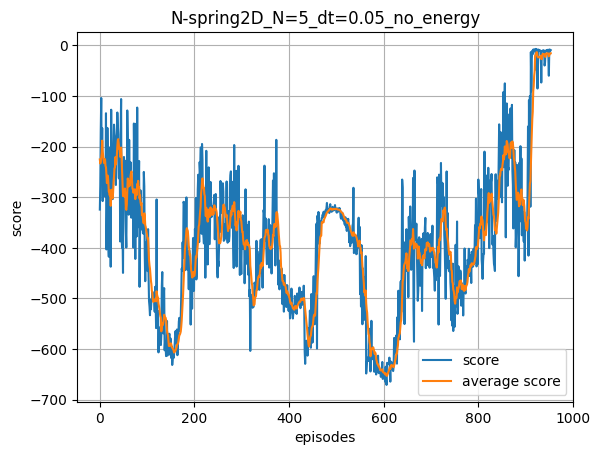

In [ ]:
env = rlmc_env("N-spring2D", 5, 0.05)  # Creat env
state_dim, action_dim = env.NNdims()
max_abs_action = 5
converge_score = -50
model_name = "N-spring2D_N=5_dt=0.05_no_energy"
# Create DDPG Agent
agent = DDPG(state_dim, action_dim, max_abs_action, hidden_width0=256, hidden_width1=128, batch_size=256, lr=0.0005,
              gamma=0.99, tau=0.005)
print("Simulation Start")
episodes = 2000
pretrain_episodes = 100
steps = 300
scores = []
rb = ReplayBuffer(state_dim, action_dim)
for episode in range(episodes + pretrain_episodes):
    env.reset_random(5.0)
    state = env.get_current_state(n_dt=1)
    score = 0
    done = False
    for step in range(steps):
        action = agent.choose_action(state)
        next_state, reward, _ = env.step(action, n_dt=1)
        score += reward
        if score > converge_score and step == steps - 1:
            done = True
        rb.store(state, action, reward, next_state, int(done))
        agent.learn(rb)
        state = next_state
    scores.append(score)
    if len(scores) < 10:
        print("Episode {} average score: {}".format(episode, sum(scores) / len(scores)))
    else:
        print("Episode {} average score: {}".format(episode, sum(scores[-10:]) / 10))
    if episode > 200 and sum(scores[-50:]) / 50 > converge_score:
        break

save_model(agent.actor, model_name)
list2txt(scores, model_name)
plot1(scores, pretrain_episodes, 10, model_name)